<img src="assets/ucu-bg.jpg" alt="UCU Machine Learning Workshops 2017" style="height: 400px; border: 2px solid #C08050">

# Practice: Day 4

## Paraphrase Identification on Quora Question Dataset

You are given a dataset that contains 400k pairs of question titles from Quora. For each question pair, a supervised label is given by a human annotator: whether both questions in the pair are considered to have the same intent (`is_duplicate = 1`) or not (`is_duplicate = 0`).

Note that the human judgment about a particular pair being a duplicate can be subjective, so expect some "noise" in the target values.

Your task is to build a model that, given two question titles, predicts whether they have the same intent. Some infrastructural parts are created for your convenience. Fill out the rest as you go along.

**Example Plan**

1. You should start with a baseline model, which could be cosine similarity over BoW vectors. Optionally, you can try using TF-IDF afterwards and compare the results to simple counting.
2. Then, try leveraging some pre-trained word embeddings (e.g. fastText on Wikipedia, or Word2Vec on Google News etc.) and calculating the Word Mover's Distance as a feature. You can also use this feature later in step 4.
3. Then, encode the questions as fixed-length padded sequences of word embeddings, and create a neural network (e.g. with a Multi-Layer Perceptron architecture). You might want to allocate a separate validation set for picking the hyperparameters.
4. (Advanced) Use BoW cosine similarity, TF-IDF cosine similarity, WMD, and the predictions of the neural network as features for a 2nd-level model.

**Helpful Modules and Functions**

For baseline models:

* `gensim.models.wrappers.fasttext.FastText.wmdistance`
* `sklearn.feature_extraction.text.CountVectorizer` and `sklearn.feature_extraction.text.TfIdfVectorizer`

For neural models:

* `keras.preprocessing.text.Tokenizer`
* `keras.preprocessing.sequence.pad_sequences`
* `keras.models.Sequential`

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import nltk
from nltk import word_tokenize

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

In [58]:
from sklearn.linear_model import LogisticRegression

In [6]:
%matplotlib inline

## Configuration

Make the subsequent runs reproducible.

In [7]:
RANDOM_STATE = 42

In [8]:
np.random.seed(RANDOM_STATE)

## Read Data

In [9]:
df_orig = pd.read_csv('quora-train.csv')

In [10]:
df_orig.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
df_orig.shape

(404290, 6)

In [12]:
df_orig.question2.replace(np.nan, 'nan', inplace=True)

In [13]:
df_orig

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


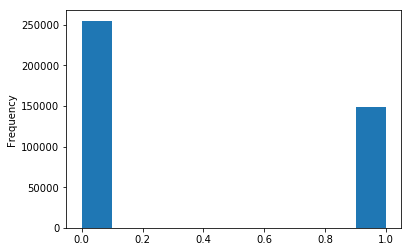

In [14]:
df_orig.is_duplicate.plot.hist()

## Partition Data

Remember the indices for the training and test sets.

In [15]:
splitter = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

In [16]:
ix_train, ix_test = next(splitter.split(df_orig, df_orig.is_duplicate))

In [17]:
print('Training set length:', ix_train.shape)
print('Test set length:    ', ix_test.shape)

Training set length: (323432,)
Test set length:     (80858,)


In [18]:
ix_test[:20]

array([ 17222, 223267, 367674, 152597, 280836,  49119, 256604, 276927,
        73028, 263616, 369062,  26570, 346428, 113762,  65671, 319720,
       217616, 238214, 187899, 191681])

In [30]:
n_train = len(ix_train)
n_test = len(ix_test)

**<span style="color: red">TODO:</span> Create features for your model.**

## Begin Modeling

Split the data.

In [19]:
train_qs = pd.Series(df_orig['question1'][ix_train].tolist() + df_orig['question2'][ix_train].tolist()).astype(str)

In [20]:
train_qs[1]

"Social Media: What does it mean when a guy deletes all of his ex's photos and comments, and even unfollowed her?"

In [21]:
vectorizer = CountVectorizer()

In [22]:
vectorizer.fit(train_qs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [23]:
features_train_q1 = vectorizer.transform(df_orig['question1'][ix_train].tolist())
features_train_q2 = vectorizer.transform(df_orig['question2'][ix_train].tolist())

features_test_q1 = vectorizer.transform(df_orig['question1'][ix_test].tolist())
features_test_q2 = vectorizer.transform(df_orig['question2'][ix_test].tolist())

In [24]:
y_train = df_orig['is_duplicate'][ix_train].values
y_test = df_orig['is_duplicate'][ix_test].values

In [25]:
print(features_train_q1.shape)
print(features_train_q2.shape)

print(features_test_q1.shape)
print(features_test_q2.shape)

(323432, 78113)
(323432, 78113)
(80858, 78113)
(80858, 78113)


**<span style="color: red">TODO:</span> Train your model.**

In [39]:
X_train = np.zeros(n_train)
for i in range(n_train):
    X_train[i] = cosine_similarity(features_train_q1[i,:], features_train_q2[i,:])[0,0]

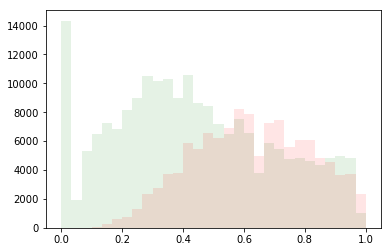

In [55]:
plt.hist(X_train[y_train == 0], bins=30, color='green', alpha = 0.1);
plt.hist(X_train[y_train == 1], bins=30, color='red', alpha = 0.1);

In [56]:
X_test = np.zeros(n_test)
for i in range(n_test):
    X_test[i] = cosine_similarity(features_test_q1[i,:], features_test_q2[i,:])[0,0]

In [57]:
print('X train:', X_train.shape)
print('y train:', y_train.shape)
print('X test: ', X_test.shape)
print('y test: ', y_test.shape)

X train: (323432,)
y train: (323432,)
X test:  (80858,)
y test:  (80858,)


**<span style="color: red">TODO:</span> Make predictions from your model.**

In [59]:
model = LogisticRegression()

In [61]:
model.fit(X_train.reshape(-1, 1), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
y_pred_train = model.predict(X_train.reshape(-1, 1))

In [67]:
y_pred_test = model.predict(X_test.reshape(-1, 1))

## Evaluate

In [68]:
def evaluate(y_true, y_pred, threshold=0.5):
    y_pred_label = y_pred >= threshold
    
    print('Log loss: ', log_loss(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred_label))
    print('Recall:   ', recall_score(y_true, y_pred_label))
    print('F1 score: ', f1_score(y_true, y_pred_label))

**Training evaluation**

In [69]:
evaluate(y_train, y_pred_train)

Log loss:  12.2437059521
Precision: 0.528071190001
Recall:    0.374708985847
F1 score:  0.438363680005


**Test evaluation**

In [70]:
evaluate(y_test, y_pred_test)

Log loss:  12.2978489245
Precision: 0.524937831371
Recall:    0.374769704887
F1 score:  0.437321658914
